In [28]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from riskyneuroarousal.modeling.prospect_theory import calc_subjective_utility
from riskyneuroarousal.utils.load_data import (load_behavioral_data, load_pupil_data, load_pt_results)
from scipy.stats import false_discovery_control
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [20]:
behavior = load_behavioral_data(min_RT = 0.2)
pupil_data = load_pupil_data()
pt_results = load_pt_results()

In [21]:
lambda_ = pt_results.query("param_name == 'lambda'")[["sub", "param_value"]].rename(columns={"param_value": "lambda"})
rho = pt_results.query("param_name == 'rho'")[["sub", "param_value"]].rename(columns={"param_value": "rho"})
mu = pt_results.query("param_name == 'mu'")[["sub", "param_value"]].rename(columns={"param_value": "mu"})
behavior = behavior.merge(lambda_, on="sub").merge(rho, on="sub").merge(mu, on="sub")

In [22]:
behavior["SV_gain"] = behavior.apply(lambda x: calc_subjective_utility(x["gain"], x["lambda"], x["rho"]), axis=1)
behavior["SV_loss"] = behavior.apply(lambda x: calc_subjective_utility(-x["loss"], x["lambda"], x["rho"]), axis=1)
behavior["SV_gamble"] = 0.5*behavior["SV_gain"] + 0.5*behavior["SV_loss"]

In [23]:
# For each subject, normalize the subjective values to range from 0 to 1
behavior["SV_gain"] = behavior.groupby("sub")["SV_gain"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
behavior["SV_loss"] = behavior.groupby("sub")["SV_loss"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
behavior["SV_gamble"] = behavior.groupby("sub")["SV_gamble"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

In [24]:
data = pupil_data.merge(behavior, on=["sub", "trial"])
data["pupil_size"] = data["ps_preprocessed"] - data["baseline"]
data["loss_over_gain"] = np.log(data["loss"] / data["gain"])

In [25]:
%%R -i data
library(mgcv)
library(lme4)
library(lmerTest)
library(dplyr)
library(broom.mixed)

Loading required package: nlme
This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.
Loading required package: Matrix

Attaching package: ‘lme4’

The following object is masked from ‘package:nlme’:

    lmList


Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step


Attaching package: ‘dplyr’

The following object is masked from ‘package:nlme’:

    collapse

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [33]:
%%R -o results_individual
# loop through timebins
results_individual <- data.frame()
for (tb in unique(data$timebin)) {
    # for each timebin, run a linear mixed effects model of ps_preprocessed
    modelIndifference = lmer(pupil_size ~ SV_gamble + RT + blink + (1| sub) + (-1 + RT|sub) + (-1 + blink | sub) +  (-1 + SV_gamble | sub), data=data[data$timebin == tb & data$condition == 'equalIndifference', ])
    modelRange = lmer(pupil_size ~ SV_gamble + blink + RT + (1| sub) + (-1 + RT|sub) + (-1 + blink | sub) + (-1 + SV_gamble | sub), data=data[data$timebin == tb & data$condition == 'equalRange', ])
    # Gather results
    resultsIndifference <- tidy(modelIndifference, effects = "fixed", conf.int = TRUE, conf.level = 0.95) 
    resultsRange <- tidy(modelRange, effects = "fixed", conf.int = TRUE, conf.level = 0.95)
    resultsIndifference$condition <- 'equalIndifference'
    resultsRange$condition <- 'equalRange'
    resultsIndifference$timebin <- tb
    resultsRange$timebin <- tb
    # Append results
    results_individual <- rbind(results_individual, resultsIndifference)
    results_individual <- rbind(results_individual, resultsRange)
}

boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
In addition: Warning messages:
1: In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :
  Model failed to converge with max|grad| = 0.00245612 (tol = 0.002, component 1)
2: In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :
  Model failed to converge with max|grad| = 0.00396693 (tol = 0.002, component 1)


In [34]:
results_individual["p.value"] = false_discovery_control(results_individual["p.value"], method = "by")
results_individual = results_individual.rename(columns={"p.value": "p_value"})

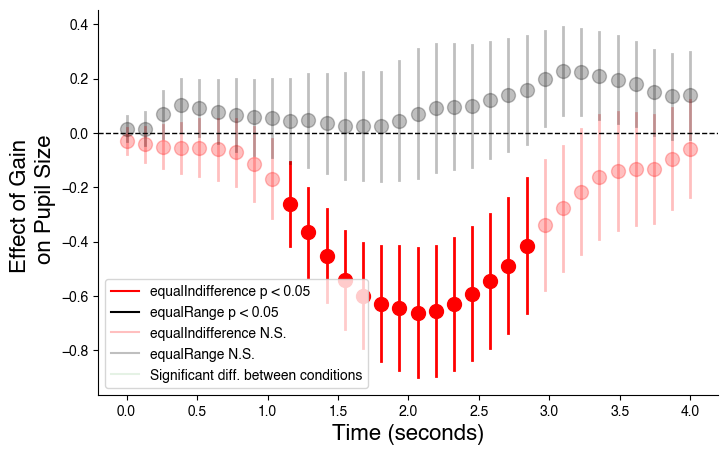

In [37]:
plt.rcParams["font.family"] = "Helvetica"
fig, ax = plt.subplots(figsize=(8, 5))
grouped_df = results_individual.query("term == 'SV_gamble'").sort_values(["timebin", "condition"]).reset_index(drop=True)

# For each timebin, plot the estimate of the gain effect for each condition. If the pvalue is not significant, alpha = 0.25
for i, row in grouped_df.iterrows():
    if row["p_value"] < 0.05:
        alpha = 1
    else:
        alpha = 0.25
    if row["condition"] == "equalIndifference":
        color = "red"
    elif row["condition"] == "equalRange":
        color = "black"
    ax.plot([row["timebin"], row["timebin"]], [row["conf.low"], row["conf.high"]], color=color, linewidth=2, alpha=alpha)
    ax.scatter(row["timebin"], row["estimate"], color=color, s=100, alpha=alpha)

ax.plot([], [], color = "red", alpha = 1, label="equalIndifference p < 0.05")
ax.plot([], [], color = "black", label="equalRange p < 0.05")
ax.plot([], [], color = "red", alpha = 0.25, label="equalIndifference N.S.")
ax.plot([], [], color = "black", alpha = 0.25, label="equalRange N.S.")
ax.plot([], [], color = "green", alpha = 0.1, label="Significant diff. between conditions")
ax.set_xlabel("Time (seconds)", fontsize=16)
ax.set_ylabel("Effect of Gain \n on Pupil Size", fontsize=16)
# Remove top and right spines
sns.despine(ax=ax, top=True, right=True)
# Add horizontal line at y=0
ax.axhline(0, color="black", linestyle="--", linewidth=1)
# Add legend where red is equalIndifference and black is equalRange
plt.legend()
plt.show()

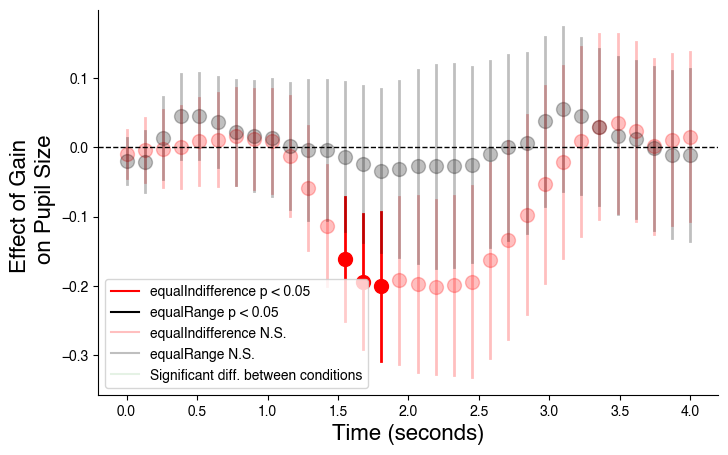

In [32]:
plt.rcParams["font.family"] = "Helvetica"
fig, ax = plt.subplots(figsize=(8, 5))
grouped_df = results_individual.query("term == 'SV_loss'").sort_values(["timebin", "condition"]).reset_index(drop=True)

# For each timebin, plot the estimate of the gain effect for each condition. If the pvalue is not significant, alpha = 0.25
for i, row in grouped_df.iterrows():
    if row["p_value"] < 0.05:
        alpha = 1
    else:
        alpha = 0.25
    if row["condition"] == "equalIndifference":
        color = "red"
    elif row["condition"] == "equalRange":
        color = "black"
    ax.plot([row["timebin"], row["timebin"]], [row["conf.low"], row["conf.high"]], color=color, linewidth=2, alpha=alpha)
    ax.scatter(row["timebin"], row["estimate"], color=color, s=100, alpha=alpha)

ax.plot([], [], color = "red", alpha = 1, label="equalIndifference p < 0.05")
ax.plot([], [], color = "black", label="equalRange p < 0.05")
ax.plot([], [], color = "red", alpha = 0.25, label="equalIndifference N.S.")
ax.plot([], [], color = "black", alpha = 0.25, label="equalRange N.S.")
ax.plot([], [], color = "green", alpha = 0.1, label="Significant diff. between conditions")
ax.set_xlabel("Time (seconds)", fontsize=16)
ax.set_ylabel("Effect of Gain \n on Pupil Size", fontsize=16)
# Remove top and right spines
sns.despine(ax=ax, top=True, right=True)
# Add horizontal line at y=0
ax.axhline(0, color="black", linestyle="--", linewidth=1)
# Add legend where red is equalIndifference and black is equalRange
plt.legend()
plt.show()